[*********************100%***********************]  1 of 1 completed

Best Alpha: 10
Best Cross-Validation RMSE: 0.02125785736711865
Train RMSE: 0.020946142130349992
Test RMSE: 0.018950605995133773


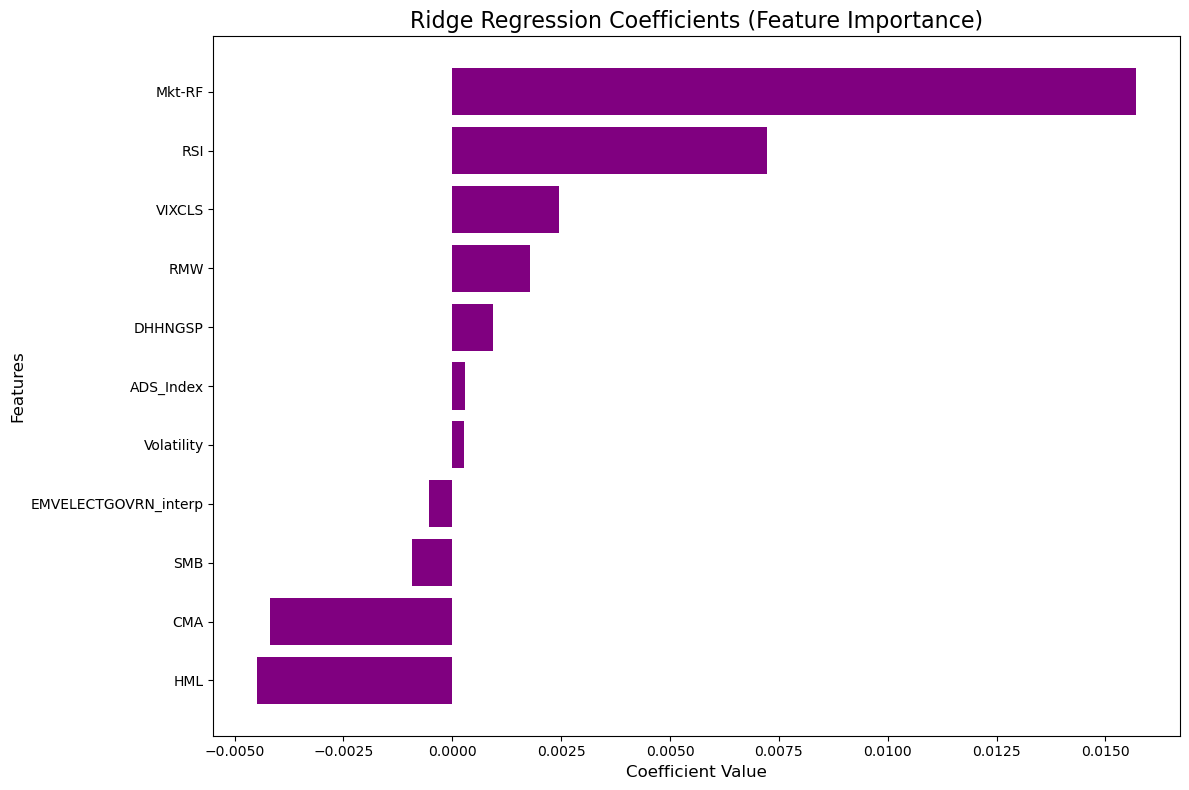

In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Step 1: Download Meta stock data for the specified time frame
meta_data = yf.download("META", start="2020-01-01", end="2024-08-30", interval="1d")

# Reset index to make 'Date' a column
meta_data.reset_index(inplace=True)

# Calculate log returns for Meta stock
meta_data["Log Return"] = np.log(meta_data["Close"] / meta_data["Close"].shift(1))
meta_data = (
    meta_data.dropna()
)  # Drop rows with NaN values caused by the shift operation

# Keep only relevant columns: Date and Log Return
meta_data = meta_data[["Date", "Log Return"]]

# Step 2: Load the provided dataset (3.csv)
file_path = "C:/Users/aqeel/work/NEU/DS INFO6105/final_dashboard/data/3.csv"  # Update if necessary
data = pd.read_csv(file_path)

# Convert the 'Date' column to datetime for both datasets
data["Date"] = pd.to_datetime(data["Date"])
meta_data["Date"] = pd.to_datetime(meta_data["Date"])

# Drop 'log_return' column from 3.csv if it exists
if "log_return" in data.columns:
    data = data.drop(columns=["log_return"])

# Flatten the multi-level columns in meta_data
meta_data.columns = [
    col[0] if col[1] == "" else f"{col[0]}_{col[1]}" for col in meta_data.columns
]


# Step 3: Align datasets by date using an inner join
merged_data = pd.merge(data, meta_data, on="Date", how="inner")

# Handle missing values in features by imputing with the mean
merged_data.fillna(merged_data.mean(), inplace=True)

# Step 4: Define features (X) and target (y)
X = merged_data.drop(columns=["Date", "Log Return"])  # Drop irrelevant columns
y = merged_data["Log Return"]

# Step 5: Eliminate problematic features
# 5.1 Remove features with high VIF
X_vif = add_constant(X)  # Add constant for intercept
vif = pd.DataFrame()
vif["Feature"] = X_vif.columns
vif["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
high_vif_features = vif[vif["VIF"] > 10]["Feature"].tolist()
X = X.drop(columns=high_vif_features, errors="ignore")

# 5.2 Remove low variance features
low_variance_features = X.columns[X.var() < 0.01].tolist()
X = X.drop(columns=low_variance_features, errors="ignore")

# 5.3 Remove highly correlated features
correlation_threshold = 0.8
corr_matrix = X.corr().abs()
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)
high_corr_features = [
    column
    for column in upper_triangle.columns
    if any(upper_triangle[column] > correlation_threshold)
]
X = X.drop(columns=high_corr_features, errors="ignore")

# Step 6: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 7: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Step 8: Tune hyperparameters using GridSearchCV
ridge_params = {"alpha": [0.01, 0.1, 1, 10, 100]}
ridge_model = Ridge()
grid_search = GridSearchCV(
    ridge_model, ridge_params, scoring="neg_mean_squared_error", cv=5
)
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_["alpha"]
best_score = np.sqrt(-grid_search.best_score_)

print(f"Best Alpha: {best_alpha}")
print(f"Best Cross-Validation RMSE: {best_score}")

# Step 9: Train Ridge Regression with the best hyperparameter
final_model = Ridge(alpha=best_alpha)
final_model.fit(X_train, y_train)

# Step 10: Evaluate the model
train_preds = final_model.predict(X_train)
test_preds = final_model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

# Step 11: Visualize coefficient magnitudes for feature importance
coefficients = pd.DataFrame({"Feature": X.columns, "Coefficient": final_model.coef_})
coefficients = coefficients.sort_values(by="Coefficient", ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(coefficients["Feature"], coefficients["Coefficient"], color="purple")
plt.title("Ridge Regression Coefficients (Feature Importance)", fontsize=16)
plt.xlabel("Coefficient Value", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [4]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Create a pipeline for scaling, polynomial features, and Ridge Regression
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "poly",
            PolynomialFeatures(degree=2, include_bias=False),
        ),  # Adding non-linear relationships
        ("ridge", Ridge()),
    ]
)

# Define hyperparameters for GridSearchCV
param_grid = {
    "ridge__alpha": [1, 10, 100, 500],  # Explore different regularization strengths
    "poly__degree": [1, 2],  # Test linear and quadratic relationships
}

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation RMSE:", np.sqrt(-grid_search.best_score_))


Best Parameters: {'poly__degree': 1, 'ridge__alpha': 10}
Best Cross-Validation RMSE: 0.021259947756610623
